In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from collections import Counter
import json
import os.path as path
import pickle
import pandas as pd

In [2]:
#load in the data by year
def loader_data(year = 103):
    Respresentatives_ids = pd.read_csv(str(year)+"_SpeakerMap.txt", sep =  "|")
    Senator_meta = Respresentatives_ids[Respresentatives_ids["chamber"] == "S"]
    Senator_ids = list(set(Senator_meta["speakerid"]))
    Respresentatives_bygrams = pd.read_csv("byspeaker_2gram_"+str(year)+".txt", sep =  "|")
    partisan_bygrams = pd.read_csv("partisan_phrases_"+str(year)+".txt", sep =  "|")
    return Senator_ids, Respresentatives_bygrams,partisan_bygrams, Respresentatives_ids

#senator_vectoriser creates a dictionary for each senator with keys the frequency of the thousand partisan bigrams
def senator_vectoriser(Senator_ids, Respresentatives_bygrams, partisan_bygrams):
    senator2vocab = {new_list: {} for new_list in Senator_ids}

    for sen_index in senator2vocab:
        senator_bigram = Respresentatives_bygrams[Respresentatives_bygrams["speakerid"] == sen_index]["phrase"].tolist()
        senator_bigram_counts = Respresentatives_bygrams[Respresentatives_bygrams["speakerid"] == sen_index]["count"].tolist()
        senator2vocab[sen_index] = dict(zip(senator_bigram,senator_bigram_counts))
        
    partisan_bygrams_lst =list((zip(partisan_bygrams.phrase.tolist(), partisan_bygrams.partisanship.tolist())))
    partisan_bygrams_lst.sort(key=lambda a:(a[1]))
    partisan_bigrams = {bigram_text: (i, partisan_score) 
                        for i, (bigram_text, partisan_score) in enumerate(partisan_bygrams_lst)}
    
    senator2vector = {i: [] for i in Senator_ids}
    for senator, vocab in senator2vocab.items():
        senator_partisan_bigrams = set(vocab.keys()).intersection(
            set(partisan_bigrams.keys()))

        temp = [0 for _ in range(len(partisan_bigrams))]
        for b in senator_partisan_bigrams:
            i = partisan_bigrams[b][0]
            temp[i] = vocab[b]
        senator2vector[senator] = temp
    return senator2vector

#normaliser normalises the senator vector by the sum of the partisan vector frequencies to 1
def normaliser(senator2vector):

    senator2vector_normalised = {} 

    for senator in senator2vector:
        summed_bigram = sum(senator2vector[senator])
        bigram_count_lst = []

        for ind, bigram_count in enumerate(senator2vector[senator]):
            if summed_bigram > 0:
                bigram_count_lst.append(bigram_count/summed_bigram)
            else:
                bigram_count_lst.append(0)
        senator2vector_normalised[senator] = bigram_count_lst
        
    
    senator2vector_normalised_ = {}
    for senator in senator2vector_normalised.keys():
        if sum(senator2vector_normalised[senator]) < 0.9:
            continue 
        else:
            senator2vector_normalised_[senator] = senator2vector_normalised[senator]
    return senator2vector_normalised_

#cluster creates senator clusters using hierachical AgglomerativeClustering with average linkage and cosine similarity 
def cluster(senator2vector_normalised, distance = 0):
    X = np.array(list(senator2vector_normalised.values())) #sum_bigram_count #senator2vector
    clustering = AgglomerativeClustering(n_clusters = None, linkage = "average", distance_threshold = distance , affinity = "cosine").fit(X)
    return clustering

#party_vector creates a list senator clusters including metadata of state, party and name
def party_vector(Senator_ids, Respresentatives_ids, clustering):
    party_lst = []
    state_lst = []
    name_lst = []

    for sen in Senator_ids: 
        # print(sen)
        party_lst.append(Respresentatives_ids[Respresentatives_ids["speakerid"] == sen].party.tolist()[0])
        if party_lst[len(party_lst)-1] == "I":
            party_lst[len(party_lst)-1] = "D"
        state_lst.append(Respresentatives_ids[Respresentatives_ids["speakerid"] == sen].state.tolist()[0])
        lastname = Respresentatives_ids[Respresentatives_ids["speakerid"] == sen].lastname.tolist()[0]
        firstname = Respresentatives_ids[Respresentatives_ids["speakerid"] == sen].firstname.tolist()[0]
        name_lst.append(firstname+" "+lastname)
    
    party_vec = list(zip(list(clustering.labels_), party_lst, state_lst, name_lst))
    return party_vec

#puirty_calculator produces a score (purity) for each cluster, 
#this is the precentage of Democrats in each cluster transformed by a quadartic function (that penalises clusters of 50% from each party), 
#this purity score is weighted by number of elements of the cluster,
#then normalised dividing by (the number of elements in cluster/total number of senators)
def puirty_calculator(clustering, party_vec):
    cluster_dic = { i:[] for i in range(max(clustering.labels_+1))}
    for senator in party_vec:
        cluster_dic[senator[0]].append(senator[1])

    purity = []
    for i in cluster_dic:        
        demo_score = (Counter(cluster_dic[i])['D']/len(cluster_dic[i]))
        score = ((4*(demo_score**2) - 4*demo_score +1) * len(cluster_dic[i]))*(len(cluster_dic[i])/len(Senator_ids))
        purity.append(score)
    
    return purity

#purity_finder then finds the purity score for each cluster distance, and returns the party vector for the optimal distance threshold
def purity_finder(senator2vector_normalised, Senator_ids, Respresentatives_ids):
    
    metric_dct = {}
    for distance in range(0,100,1):
        clustering = cluster(senator2vector_normalised, distance/100)
        
        cluster_dic = {i:[] for i in range(max(clustering.labels_+1))}
        party_vec = party_vector(Senator_ids, Respresentatives_ids, clustering)
        party_vec.sort(key=lambda a:(a[0]))
        purity = puirty_calculator(clustering, party_vec)
        
        metric_dct[distance/100] = sum(purity)
    
    best_dist = list(metric_dct.keys())[list(metric_dct.values()).index(max(metric_dct.values()))]
    party_vec = party_vector(Senator_ids, Respresentatives_ids, cluster(senator2vector_normalised, best_dist))
    party_vec.sort(key=lambda a:(a[0]))
    return [best_dist, metric_dct[best_dist], party_vec, metric_dct]

#purity_finder then finds the purity score for each cluster distance, and returns the party vector for the optimal distance threshold
def purity_finder(senator2vector_normalised, Senator_ids, Respresentatives_ids):
    
    metric_dct = {}
    for distance in range(0,100,1):
        clustering = cluster(senator2vector_normalised, distance/100)
        
        cluster_dic = {i:[] for i in range(max(clustering.labels_+1))}
        party_vec = party_vector(Senator_ids, Respresentatives_ids, clustering)
        party_vec.sort(key=lambda a:(a[0]))
        purity = puirty_calculator(clustering, party_vec)
        metric_dct[distance/100] = sum(purity)
    
    best_dist = list(metric_dct.keys())[list(metric_dct.values()).index(max(metric_dct.values()))]
    party_vec = party_vector(Senator_ids, Respresentatives_ids, cluster(senator2vector_normalised, best_dist))
    party_vec.sort(key=lambda a:(a[0]))
    return [best_dist, metric_dct[best_dist], party_vec, metric_dct]

In [11]:
#this function finds the optimal cluster for each congressional session based on purity score,
#returns a dictionay of sessions as keys and values the optimal score, distance threshold, number of senators, party vector

year_issues = {}
for i in range(97,115):
    if i < 100:
        year_issues["0"+str(i)] = []
    else:
        year_issues[str(i)] = []

for year in year_issues:
    print(year)
    Senator_ids, Respresentatives_bygrams,partisan_bygrams, Respresentatives_ids = loader_data(year)
    senator2vector = senator_vectoriser(Senator_ids, Respresentatives_bygrams, partisan_bygrams)
    senator2vector_normalised = normaliser(senator2vector)
    year_issues[year] = purity_finder(senator2vector_normalised, Senator_ids, Respresentatives_ids)
    
#this function saves final output dictionary
# out_path = "year_issues_partisan.pkl"
# with open(out_path, 'wb') as f_out:
#     pickle.dump(year_issues, f_out)
    
#this function reads in the saved output
issue_by_year_ = pd.read_pickle(r'year_issues_partisan.pkl')

097
098
099
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


In [4]:
#this cell produce the necessary variables for plotting the precentage democratics across each cluster
for year in issue_by_year_:
    current_year = Counter([a[0:2] for a in issue_by_year_[year][2]])

    lst__ = []
    for i in issue_by_year_[year][2]:
        lst__.append(i[0:2])

    lst__1 = []
    for i in range(max(lst__)[0]):
        lst__1.append((i,"R"))
        lst__1.append((i,"D"))
    
    j = (-1,"z")
    if year == "097":
        hist_lst = []
    for i in lst__1:
        # print(i, current_year[i])
        if j[0] == i[0]:
            # print((current_year[i])/(current_year[i]+current_year[j]))
            hist_lst.append((current_year[i])/(current_year[i]+current_year[j]))
        j = i

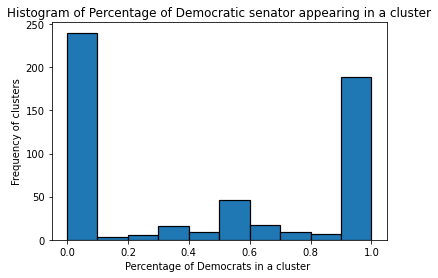

In [13]:
plt.hist(hist_lst, edgecolor='black', linewidth=1.2)
plt.title("Histogram of Percentage of Democratic senator appearing in a cluster")
plt.xlabel("Percentage of Democrats in a cluster ")
plt.ylabel("Frequency of clusters")
plt.show()